In [1]:
using CairoMakie
using FourierFlows
using FourierFlows: parsevalsum2
using JLD2
using Printf
using LinearAlgebra: ldiv!
using AbstractFFTs
include("../../utils/ExactRadialSpectrum.jl")

set_top_clip_weights (generic function with 1 method)

In [2]:
initial_data_file = jldopen("/scratch/nad9961/swqg_fourier/59775358/1/radial_data_k=001.jld2")
println(initial_data_file["k"])
N = length(initial_data_file["t"])
N_half = Int((N)//2)
t = initial_data_file["t"][2:end]
dt = t[2] - t[1]
ω = fftshift(fftfreq(N, 1/dt)) * 2*pi
close(initial_data_file)

0.0


In [3]:
grid = TwoDGrid(; Lx=2π, nx=512)
radii, weight_matrix = create_radialspectrum_weights(grid, 2);

ψ_data = zeros(N, length(radii))

k_max = 256
for k_idx=1:k_max
    data_file = nothing
    filename = @sprintf("/scratch/nad9961/swqg_fourier/59775358/%d/radial_data_k=%03d.jld2", ceil(Int,k_idx/4), k_idx)
    
    if !isfile(filename) 
        println("Missing file: " * filename)
        continue
    end
    println(filename)
    data_file = jldopen(filename)
    chosen_weights = [weights[k_idx, :] for weights=weight_matrix]
    ψtslice = eachslice(abs2.(data_file["ψt"]), dims=1)
    ψ_data += chosen_weights' .* ψtslice
    close(data_file)
    data_file = nothing
    GC.gc()
end

/scratch/nad9961/swqg_fourier/59775358/1/radial_data_k=001.jld2
/scratch/nad9961/swqg_fourier/59775358/1/radial_data_k=002.jld2
/scratch/nad9961/swqg_fourier/59775358/1/radial_data_k=003.jld2
/scratch/nad9961/swqg_fourier/59775358/1/radial_data_k=004.jld2
/scratch/nad9961/swqg_fourier/59775358/2/radial_data_k=005.jld2
/scratch/nad9961/swqg_fourier/59775358/2/radial_data_k=006.jld2
/scratch/nad9961/swqg_fourier/59775358/2/radial_data_k=007.jld2
/scratch/nad9961/swqg_fourier/59775358/2/radial_data_k=008.jld2
/scratch/nad9961/swqg_fourier/59775358/3/radial_data_k=009.jld2
/scratch/nad9961/swqg_fourier/59775358/3/radial_data_k=010.jld2
/scratch/nad9961/swqg_fourier/59775358/3/radial_data_k=011.jld2
/scratch/nad9961/swqg_fourier/59775358/3/radial_data_k=012.jld2
/scratch/nad9961/swqg_fourier/59775358/4/radial_data_k=013.jld2
/scratch/nad9961/swqg_fourier/59775358/4/radial_data_k=014.jld2
/scratch/nad9961/swqg_fourier/59775358/4/radial_data_k=015.jld2
/scratch/nad9961/swqg_fourier/59775358/4

In [4]:
function frequency_filters(N)
    # Returns negative zero, and positive frequency filters
    if (N % 2 == 0)
        N_half = Int(N//2)+1
        return (N_half-1):-1:2, N_half, (N_half+1):N
    else
        N_half = Int((N+1)//2)
        return (N_half-1):-1:1, N_half, (N_half+1):N
    end
    
end

frequency_filters (generic function with 1 method)

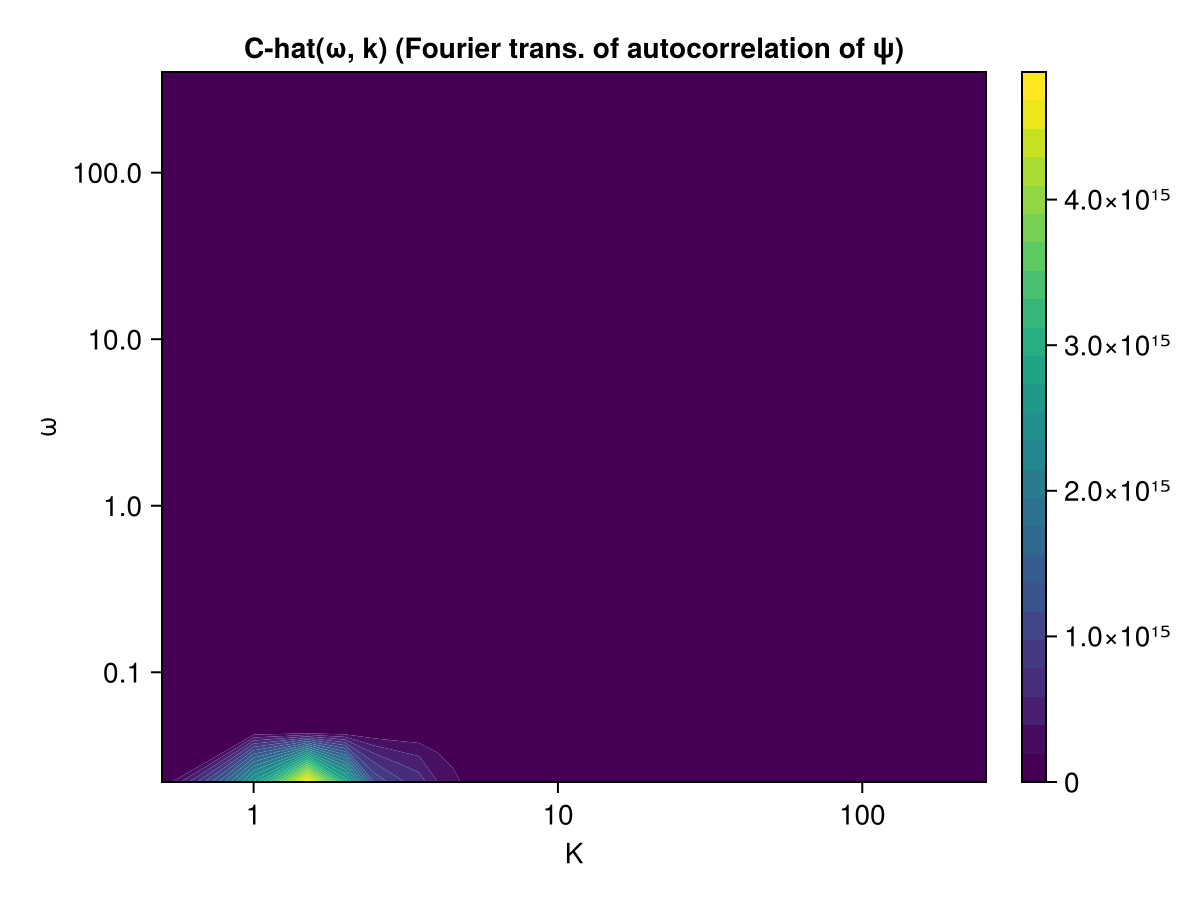

In [5]:
N_neg, N_half, N_pos = frequency_filters(N)

plot_data = fftshift(ψ_data, 1)'
plot_data = plot_data[:, N_neg] + plot_data[:, N_pos]

fig = Figure()
ax = Axis(fig[1,1]; xscale=log10, yscale=log10, xlabel="K", ylabel="ω", title="C-hat(ω, k) (Fourier trans. of autocorrelation of ψ)",
    xticks=[1, 10, 100], yticks=[0.1, 1, 10, 100])

cf = contourf!(ax, radii, ω[N_pos], plot_data, levels=25)
cb = Colorbar(fig[1,2], cf)

save("images/C-hat.png", fig)
fig

In [6]:
using Interpolations
dω = ω[end] - ω[end-1]
ω_interps = range(0, ω[end], length=length(N_pos)+1)
autocor_interp = linear_interpolation((ω, (radii .- 0.5)), ψ_data)

function integrand(q, η, autocor_val)
    return q^5 * autocor_val * sin(η)^2 * cos(η)^2
end

function integrate(autocor, k_val, dispersion_relation)
    η_max = 2π
    dη = 0.1
    
    q_max = 254.5
    dq = 0.1
    
    η_range = 1:dη:η_max
    q_range = 0:dq:q_max
    total = 0

    c = dispersion_relation(k_val)
    for q=q_range
        for η=η_range
            autocor_val = autocor[-q*c*cos(η), q]
            total += integrand(q, η, autocor_val) * dq * dη
        end
    end
    return total
end

Cg = 1
f = 3
dispersion_relation(k) = Cg * k /sqrt.(f^2 + Cg^2*k^2)

k_vals = 0:0.5:100
D_vals = zeros(length(k_vals))
for i=1:length(k_vals)
    D_vals[i] = k_vals[i]^2/(2*(2π)^2)*integrate(autocor_interp, k_vals[i], dispersion_relation)
end

In [8]:
D_vals ./ k_vals.^2

201-element Vector{Float64}:
 NaN
   0.02235036405862949
   0.022385291641551744
   0.02248038529256162
   0.022572539073933053
   0.02267728543334081
   0.022786101782870244
   0.02287621454871821
   0.022936454986416624
   0.02303054928258727
   0.02308533746394594
   0.023110552290032366
   0.023154051050897392
   ⋮
   0.02344148570401587
   0.023441624877681155
   0.023441752390799358
   0.023441900525029234
   0.02344202761167792
   0.023442145337460234
   0.02344228149453815
   0.023442377740900418
   0.023442426971500865
   0.023442535206244675
   0.02344265638607353
   0.02344272310019807

In [17]:
data_file = jldopen("/vast/nad9961/swqg/59723713/qgsw.000001.jld2")
frames = keys(data_file["snapshots/sol"])
qh = data_file["snapshots/sol/" * frames[end]]
grid = TwoDGrid(;Lx=2π, nx=512)
Kd2 = f^2 / Cg^2
ψh = -qh ./ (grid.Krsq .+ Kd2)
uh = -1im * grid.l  .* ψh
vh =  1im * grid.kr .* ψh
u = irfft(uh, grid.nx)
v = irfft(vh, grid.nx)
rms_U = sqrt.(sum(u.^2 + v.^2) / grid.nx / grid.ny)
Fr = rms_U / Cg
possible_b = f * Fr^3

0.0010125526188604112

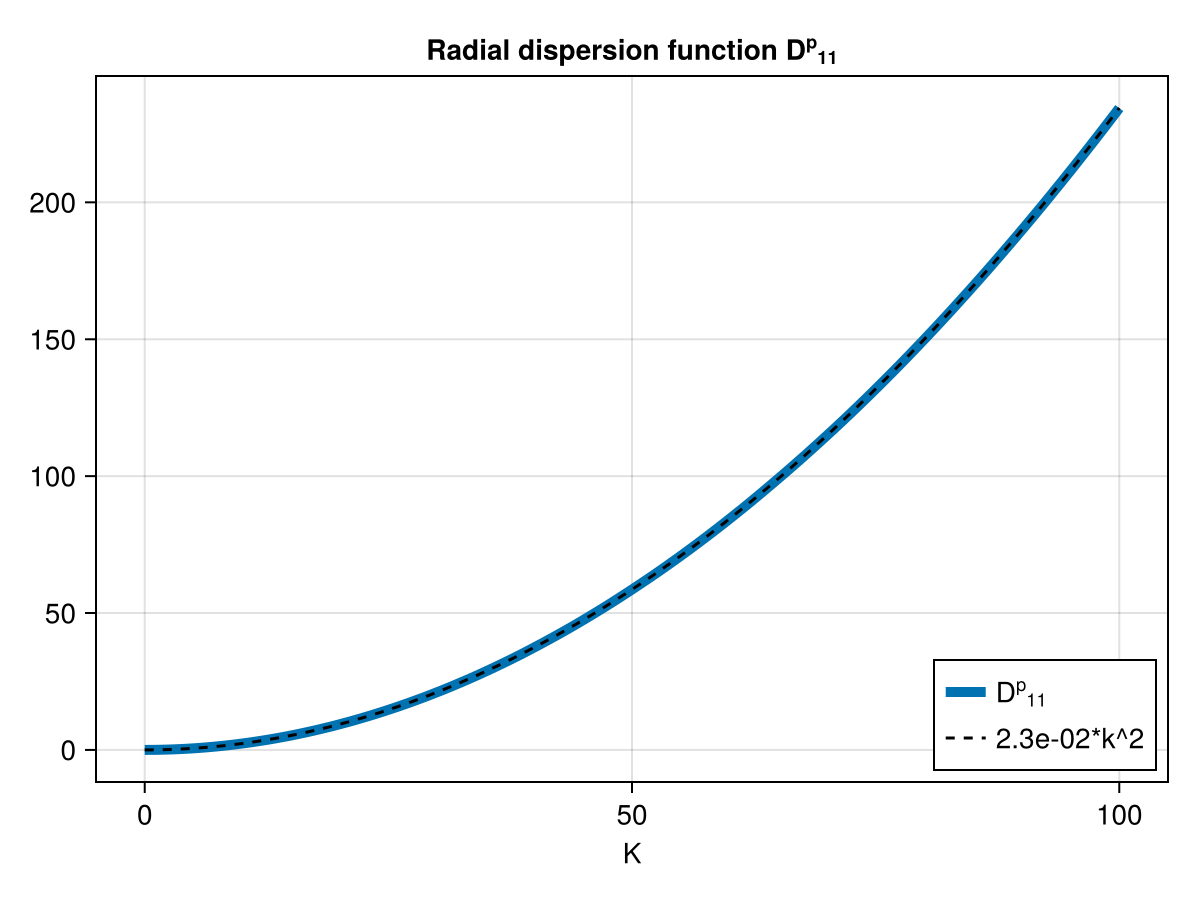

In [16]:
fig = Figure()
ax = Axis(fig[1,1]; title=rich("Radial dispersion function ", "D", superscript("p"), subscript("11")), xlabel="K")
lines!(ax, k_vals, D_vals, linewidth=5, label=rich("D", superscript("p"), subscript("11")))
lines!(ax, k_vals, D_vals[end]/k_vals[end]^2*k_vals.^2, linestyle=:dash, color=:black, label=@sprintf("%0.1e*k^2", D_vals[end]/k_vals[end]^2))
axislegend(ax, position=:rb)

save("images/radial_disperionsion.png", fig)
fig

In [125]:
dω

0.061912238667389374

In [109]:
ψ_data[N_pos, :] + ψ_data[N_neg, :]

6112×510 Matrix{Float64}:
 0.0      5.78287e-7      1.0495e-6   …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0      5.48696e-7      1.83594e-6     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0      4.73659e-7      1.37204e-6     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0      5.18757e-7      1.51371e-6     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0      6.36562e-7      1.33842e-6     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0      7.72801e-7      1.43203e-6  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0      5.06918e-7      1.3175e-6      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0      9.25617e-7      2.29638e-6     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0      1.52006e-6      3.50107e-6     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0      9.84967e-7      2.04044e-6     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0      3.84515e-7      9.99967e-7  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0      4.35046e-7      1.47744e-6     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0      6.63957e-7      1.39392e-6     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [100]:
N_neg

6113:-1:2

In [101]:
N_half

6114

In [104]:
ω[N_half+1]

0.06191223866739001

In [105]:
radii

0.5:0.5:255.0